In [94]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import interpolate

**Discrete/Interpolation - Stochastic - Policy time iteration**

In [13]:
beta = 0.9   # discount factor
nk = 30      # capital grid points
delta = 0    # depreciation rate

eps = 1e-5         # convergence criterion
max_iter = 1000    # maximum number of iterations

In [3]:
# Utility mode
# 0: log utility
# 1: u(c) = - c ** (-4)
utility_mode = 0

In [4]:
def utility(c, utility_mode):
    if utility_mode == 0:
        u = math.log(c)
    else:
        u = -c ** (-4)

    return u

In [5]:
def uprime(c, utility_mode):
    if utility_mode == 0:
        up = 1 / c
    else:
        up = (-4) * c ** (-3)
    return up

In [52]:
def euler(kprime_log, k, kgrid, fk, s, g, utility_mode, interpolation_mode):

    kprime = np.exp(kprime_log)

    lhs = uprime(fk[k, s] + (1 - delta) * kgrid[k] - kprime, utility_mode)

    kprime2_0 = interpolate_policy_function(kprime, g, 0, kgrid, interpolation_mode)
    kprime2_1 = interpolate_policy_function(kprime, g, 1, kgrid, interpolation_mode)

    f_0 = 0.9 * kprime ** 0.3 + 0.3 * kprime
    f_1 = 1.1 * kprime ** 0.3 + 0.9 * kprime

    fprime_0 = 0.3 * 0.9 * kprime ** (0.3 - 1) + 0.3 + 1 - delta
    fprime_1 = 0.3 * 1.1 * kprime ** (0.3 - 1) + 0.9 + 1 - delta

    rhs = beta * (0.5 * uprime(f_0 + (1 - delta) * kprime - kprime2_0, utility_mode) * fprime_0 +
                  0.5 * uprime(f_1 + (1 - delta) * kprime - kprime2_1, utility_mode) * fprime_1)

    eul = lhs - rhs

    return eul

In [65]:
def interpolate_policy_function(capital, g, s, kgrid, interpolation_mode):

    if interpolation_mode == 0:   # PIECEWISE LINEAR INTERPOLATION
        #val = linint(capital, kgrid, g[:, s])
        val = np.interp(capital, kgrid, g[:, s])

    elif interpolation_mode == 1:   # POLYNOMIAL OF DEGREE 5
        interpolant = np.polyfit(kgrid, g[:, s], 5)
        val = np.polyval(interpolant, capital)

    elif interpolation_mode == 99:   # Chebyshev polynomial of degree 5
        interpolant = np.polynomial.chebyshev.chebfit(kgrid, g[:, s],5)
        val = np.polynomial.chebyshev.chebval(capital, interpolant)    
        
    else:   # CUBIC SPLINES
        interpolant = interpolate.CubicSpline(kgrid, g[:, s])
        val = interpolant(capital)

    return val

In [53]:
def solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode):

    kgrid = np.linspace(0.001, 1, nk)  # capital grid
    fk = np.zeros((nk, 2))  # production

    # Production conditional on capital and shock
    fk[:, 0] = 0.9 * kgrid ** 0.3 + 0.3 * kgrid
    fk[:, 1] = 1.1 * kgrid ** 0.3 + 0.9 * kgrid

    # Initial guess for value function:
    V = np.zeros((nk, 2))

    # Arrays to store
    # (1) the updated value function
    Vnew = np.zeros_like(V)

    # (2) the expected future value function (expectation over shock)
    g = np.zeros((nk, 2))
    EV = np.zeros(nk)

    # Decision on consumption and investment conditional on capital and shock
    pol_c = np.zeros((nk, 2))
    pol_i = np.zeros((nk, 2))

    crit = 1  # initialize crit to 1
    iter = 0  # initialize iteration number to 0

    while crit > eps and iter < max_iter:

        # Computed expected future value
        #for k in range(nk):
        #    EV[k] = beta * (0.5 * Vnew[k, 0] + 0.5 * Vnew[k, 1])

        # Loop over all current values of capital and the shock:
        for k in range(nk):
            for s in range(2):

                fun = lambda kprime_log: euler(kprime_log, k, kgrid, fk, s, g, utility_mode, interpolation_mode)
                kprime_log = optimize.fsolve(fun, (-5) * np.ones(1))
                kprime = math.exp(kprime_log)

                # Maximal amount of consumption (for zero savings)
                max_c = fk[k, s] + (1 - delta) * kgrid[k]

                if kprime > max_c:
                    kprime = 0

                kprime = max(kprime, 0)
                kprime = min(kprime, kgrid[len(kgrid) - 1])

                c = max_c - kprime
                                                    
                #value = utility(c, utility_mode) + linint(kprime, kgrid, EV)

                #Vnew[k, s] = value   # update value function with the best utility found
                pol_i[k, s] = kprime    # also save investment choice
                pol_c[k, s] = c    # and consumption choice

        crit = np.max(np.abs(g - pol_i))    # distance between old and new value function
        V = np.copy(Vnew)   # perform the update of the value function
        g = np.copy(pol_i)

        iter += 1

    model = {}
    model['iter'] = iter
    model['crit'] = crit
    model['V'] = V
    model['pol_c'] = pol_c
    model['pol_i'] = pol_i
    model['kgrid'] = kgrid
    model['fk'] = fk

    return model

In [83]:
def plot_policy(model):

    plt.figure(figsize=(9, 4.5))
    plt.subplot(1, 2, 1)
    plt.plot(model['kgrid'], model['pol_i'][:, 0], label='Low')
    plt.plot(model['kgrid'], model['pol_i'][:, 1], label='High')
    plt.title('Investment')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model['kgrid'], model['pol_c'][:, 0], label='Low')
    plt.plot(model['kgrid'], model['pol_c'][:, 1], label='High')
    plt.legend()
    plt.title('Consumption')

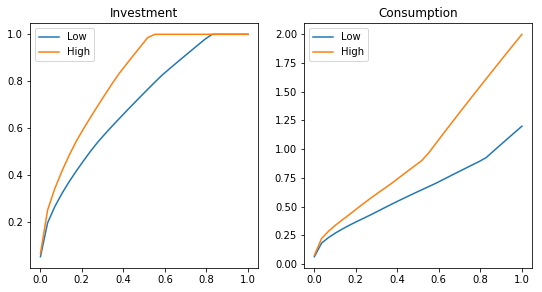

In [84]:
# Basic case

beta = 0.9
utility_mode = 0
interpolation_mode = 0

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

invest_0_0 = model['pol_i'][:, 0]
invest_0_1 = model['pol_i'][:, 1]

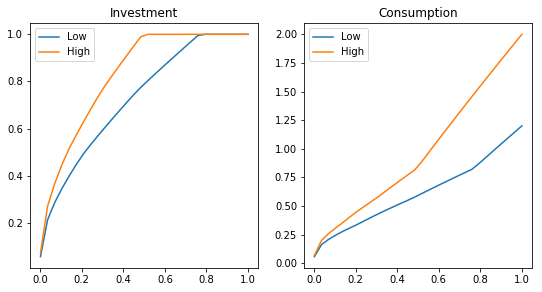

In [85]:
# 1) Alternative discount factor

interpolation_mode = 0
beta = 0.999

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

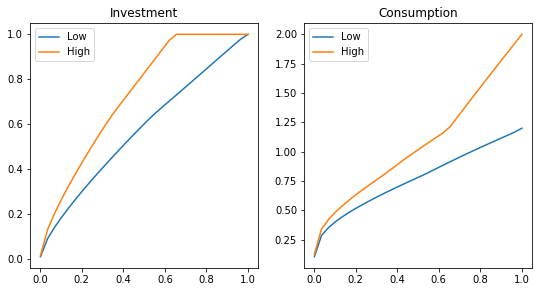

In [86]:
# 2) Alternative discount factor and utility

utility_mode = 1
interpolation_mode = 0
beta = 0.999

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

invest_2_0 = model['pol_i'][:, 0]
invest_2_1 = model['pol_i'][:, 1]

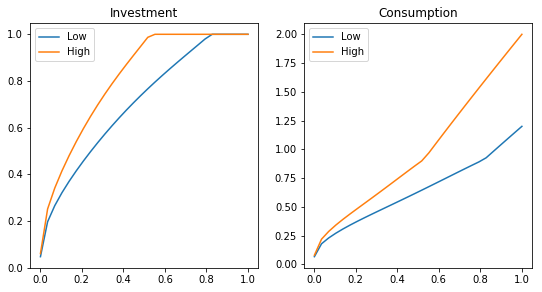

In [87]:
# 3) Log utility again, but polynomial of degree 5

beta = 0.9
utility_mode = 0
interpolation_mode = 1

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

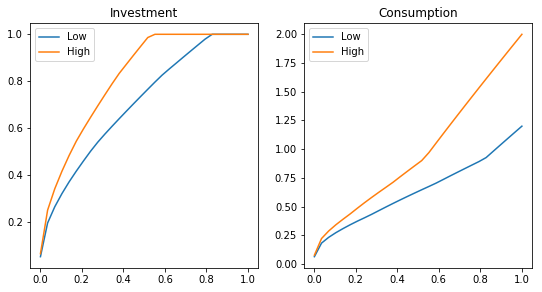

In [88]:
# 4) Log utility again, but cubic splines

beta = 0.9
utility_mode = 0
interpolation_mode = 2

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

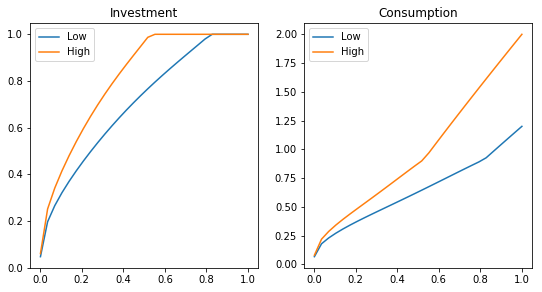

In [89]:
# 5) Chebyshev

beta = 0.9
utility_mode = 0
interpolation_mode = 99

model = solve_model_time_iteration(beta, nk, delta, eps, max_iter, utility_mode, interpolation_mode)
plot_policy(model)

invest_5_0 = model['pol_i'][:, 0]
invest_5_1 = model['pol_i'][:, 1]

**EXTRA CHECKS**

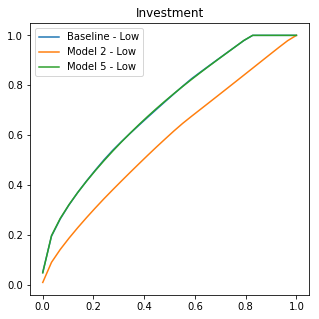

In [91]:
plt.figure(figsize=(5, 5))
plt.plot(model['kgrid'], invest_0_0[:], label='Baseline - Low')
plt.plot(model['kgrid'], invest_2_0[:], label='Model 2 - Low')
plt.plot(model['kgrid'], invest_5_0[:], label='Model 5 - Low')
plt.title('Investment')
plt.legend()

In [92]:
print(invest_0_0[:])

[0.05044447 0.19483304 0.26394063 0.32009757 0.37005993 0.41581756
 0.45909419 0.50071463 0.5390734  0.5739685  0.60724367 0.63974062
 0.67174549 0.70334106 0.73457979 0.76550438 0.79607669 0.82567144
 0.85193283 0.87774772 0.90337171 0.92882117 0.95411041 0.97925203
 1.         1.         1.         1.         1.         1.        ]


In [93]:
print(invest_5_0[:])

[0.04743856 0.19710063 0.26603064 0.32120141 0.36996526 0.41489452
 0.45715659 0.49734654 0.53578814 0.57266872 0.60810775 0.64219399
 0.67500571 0.70662148 0.73712529 0.76660863 0.79517108 0.82292037
 0.84997282 0.87645459 0.9025046  0.92827986 0.953965   0.97978912
 1.         1.         1.         1.         1.         1.        ]
